In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [22]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [23]:
!pip install treeinterpreter waterfallcharts

In [24]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [25]:
train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv', low_memory=False)
train_df.info(), store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assort

(None, None)

In [26]:
df = train_df.merge(store_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [27]:
df = add_datepart(df, 'Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 13  Promo2      

In [28]:
df.head()

,Store,DayOfWeek,Sales,Customers,...,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,5263,555,...,False,False,False,1.438301e+09
1,2,5,6064,625,...,False,False,False,1.438301e+09
2,3,5,8314,821,...,False,False,False,1.438301e+09
3,4,5,13995,1498,...,False,False,False,1.438301e+09
4,5,5,4822,559,...,False,False,False,1.438301e+09


In [29]:
dep_var = 'Sales'
df[dep_var] = np.log(df[dep_var] + 1)

In [30]:
procs = [Categorify, FillMissing]

In [31]:
cond = (df.Year<2014) | (df.Month<12)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = list(train_idx), list(valid_idx)

In [32]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [33]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [34]:
len(to.train), len(to.valid)

(988224, 28985)

In [35]:
save_pickle('to.pkl', to)
to = load_pickle('to.pkl')

In [36]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [37]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [38]:
def rf(xs, y, n_estimators=40, max_samples=200_000, 
      max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
    max_features=max_features, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [39]:
m = rf(xs, y)

In [40]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.062163, 0.101363)

In [43]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': xs.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [44]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
17,Customers,0.697979
18,Open,0.179629
31,Dayofweek,0.056835
16,DayOfWeek,0.056733
0,StateHoliday,0.004616
19,Promo,0.001047
1,StoreType,0.000648
21,CompetitionDistance,0.000622
32,Dayofyear,0.000548
15,Store,0.000300


<Axes: ylabel='cols'>

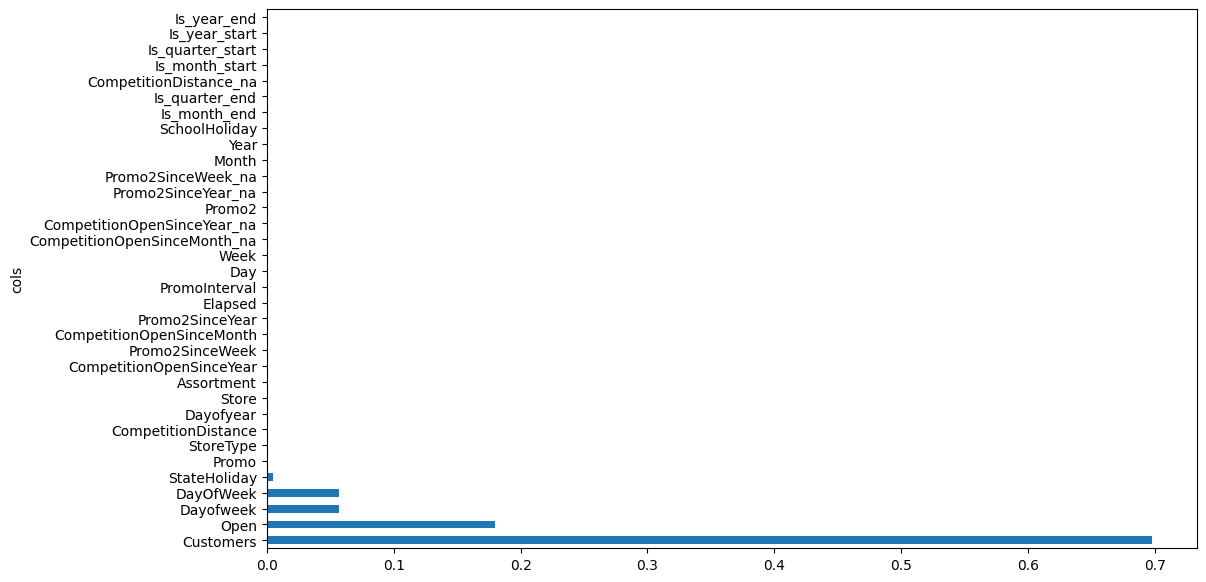

In [46]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi)

In [49]:
to_keep = fi[fi.imp>0.001].cols
len(to_keep)

6

In [50]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [51]:
m = rf(xs_imp, y)

In [52]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.17907, 0.209236)

In [54]:
len(xs.columns), len(xs_imp.columns)

(34, 6)

In [58]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':xs_imp.columns, 'imp':m.feature_importances_}
                ).sort_values('imp',ascending=False)

<Axes: ylabel='cols'>

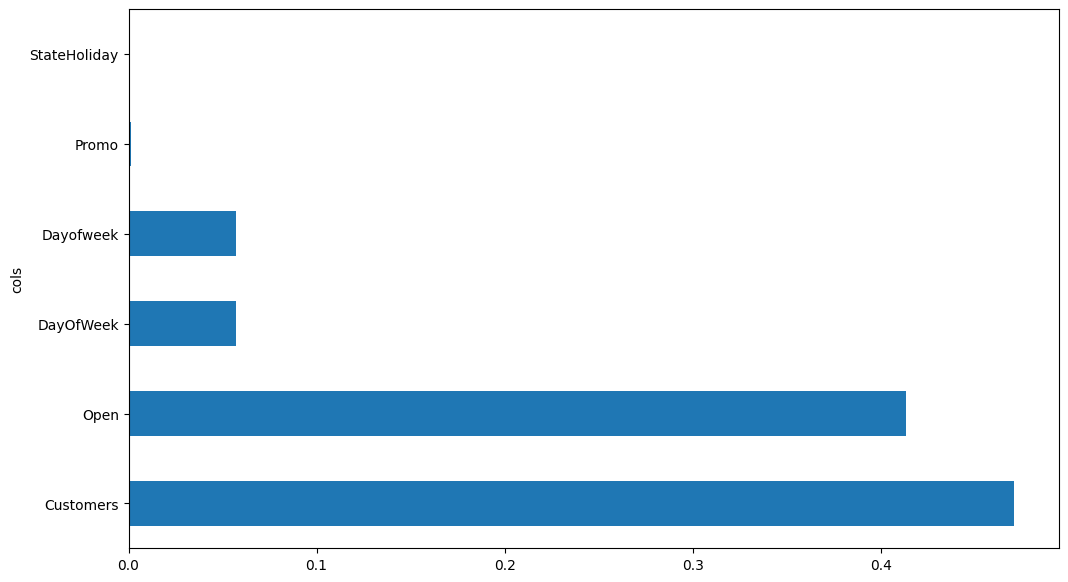

In [59]:
plot_fi(rf_feat_importance(m, xs_imp))

In [61]:
to_keep_2 = fi[fi.imp>0.002]
len(to_keep_2)

5

In [62]:
xs_imp_2 = xs_imp[to_keep]
valid_xs_imp2 = valid_xs_imp[to_keep]

In [63]:
m = rf(xs_imp_2, y)
m_rmse(m, xs_imp_2, y), m_rmse(m, valid_xs_imp2, valid_y)

(0.18044, 0.211607)

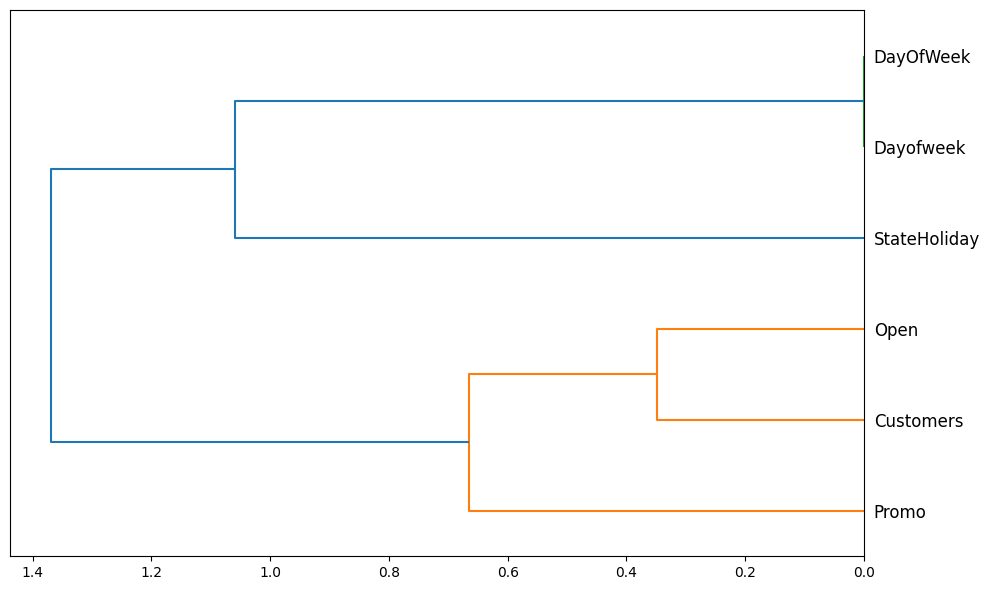

array([[2.        , 3.        , 0.        , 2.        ],
       [0.        , 1.        , 0.3489    , 2.        ],
       [5.        , 7.        , 0.6646    , 3.        ],
       [4.        , 6.        , 1.0588    , 3.        ],
       [8.        , 9.        , 1.36948889, 6.        ]])

In [64]:
from scipy.cluster import hierarchy
import numpy as np

def cluster_columns(df, figsize=(10, 6), font_size=12):
    """
    Cluster columns based on correlation and plot a dendrogram
    """
    # Calculate correlation matrix
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hierarchy.distance.squareform(1 - corr)
    z = hierarchy.linkage(corr_condensed, method='average')
    
    # Plot dendrogram
    fig = plt.figure(figsize=figsize)
    dendrogram = hierarchy.dendrogram(z, labels=df.columns, 
                                     orientation='left', 
                                     leaf_font_size=font_size)
    plt.tight_layout()
    plt.show()
    
    return z

cluster_columns(xs_imp_2)

In [69]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                             max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [70]:
get_oob(xs_imp_2)

0.9970223757151453

In [73]:
{c: get_oob(xs_imp_2.drop(c, axis=1)) for c in ('DayOfWeek', 'Dayofweek', 'Open', 'Customers') }

{'DayOfWeek': 0.9969331412399817,
 'Dayofweek': 0.996945032386562,
 'Open': 0.9969130567756532,
 'Customers': 0.9883561364895684}

In [74]:
to_drop = ['DayOfWeek', 'Open']
get_oob(xs_imp_2.drop(to_drop, axis=1))

0.9968752940040989

In [75]:
xs_final = xs_imp_2.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp2.drop(to_drop, axis=1)

In [76]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)

In [77]:
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [78]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.176838, 0.205833)

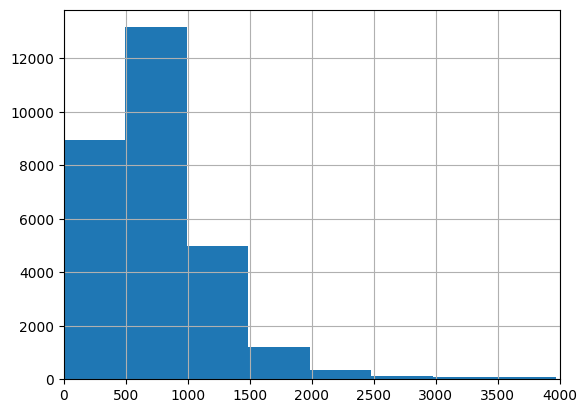

In [82]:
ax = valid_xs_final['Customers'].hist()
plt.xlim(0, 4000)
plt.show()

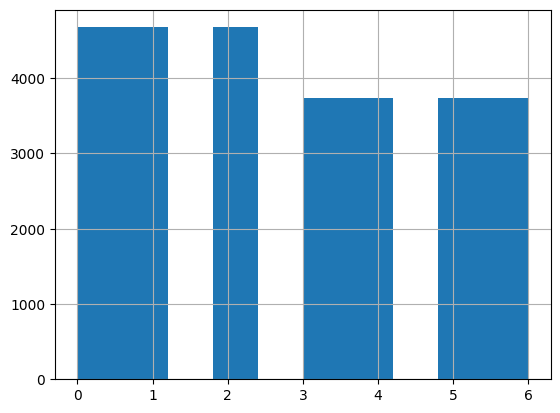

In [85]:
ax = valid_xs_final['Dayofweek'].hist()
plt.show()

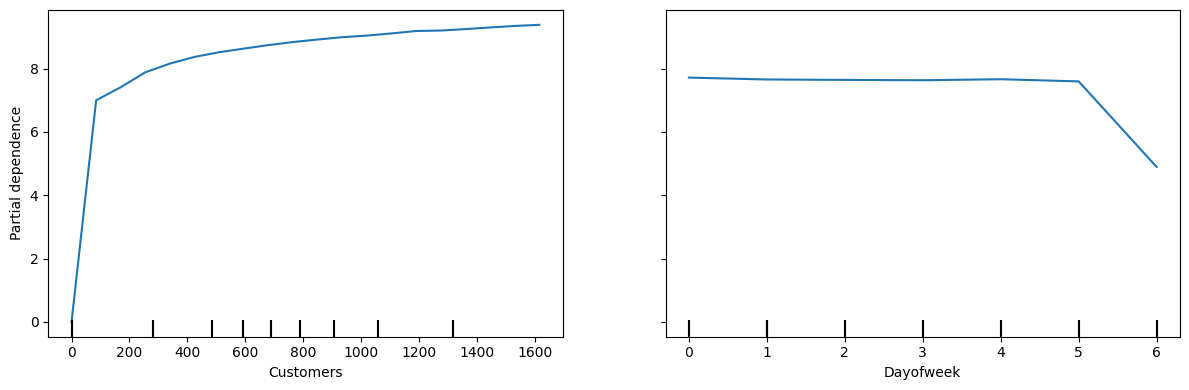

In [86]:
from sklearn.inspection import PartialDependenceDisplay

# For scikit-learn >= 1.0
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['Customers', 'Dayofweek'],
                                       grid_resolution=20, ax=ax)
plt.tight_layout()
plt.show()